In [1]:
import numpy as np
import matplotlib.pyplot as plt

eval = np.load('./logs/evaluations.npz')

[[1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 100

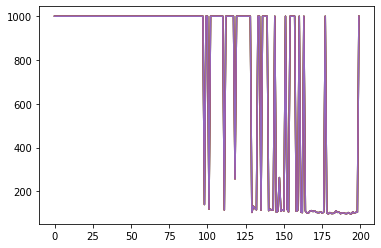

In [2]:
print(eval['ep_lengths'])
plt.plot(eval['ep_lengths'])

In [3]:
# keys are :['ep_lengths', 'results', 'timesteps']

[[-1035000. -1035000. -1035000. -1035000. -1035000.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34610.   -34610.   -34610.   -34610.   -34610.]
 [  -34700.   -34700.   -34700.   -34700.   -34700.]
 [  -34520.   -34520.   -34520.   -34520.   -34520.]
 [  -34520.   -34520.   -34520.   -34520.   -34520.]
 [  -34580.   -34580.   -34580.   -34580.   -34580.]
 [-1013370. -1013370. -1013370. -1013370. -1013370.]
 [  -34670.   -34670.   -34670.   -34670.   -34670.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34610.   -34610.   -34610.   -34610.   -34610.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34490.   -34490.   -34490.   -34490.   -34490.]
 [  -34730.   -34730.   -34730.   -34730.   -3

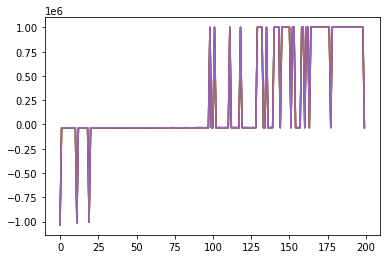

In [4]:
print(eval['results'])
plt.plot(eval['results'])